In [1]:
#!/usr/bin/env python
# coding: utf-8
# Based on basic_rl.py (v0.0.1): https://gist.github.com/tanemaki/d979dc7b9e59c73b48a118f6034c99c4

import sys
import argparse
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def parse_arguements(arguments):
    parser = argparse.ArgumentParser(description='Use SARSA/Q-learning algorithm with epsilon-greedy/softmax polciy.')
    parser.add_argument('-a', '--algorithm', default='sarsa', choices=['sarsa', 'q_learning'], help="Type of learning algorithm. (Default: sarsa)")
    parser.add_argument('-p', '--policy', default='epsilon_greedy', choices=['epsilon_greedy', 'softmax'], help="Type of policy. (Default: epsilon_greedy)")
    parser.add_argument('-e', '--environment', default='FrozenLake-v0', help="Name of the environment provided in the OpenAI Gym. (Default: FrozenLake-v0)")
    parser.add_argument('-n', '--nepisode', default='10000', type=int, help="Number of episode. (Default: 5000)")
    parser.add_argument('-t', '--treshold', default='1', type=float, help="Minimum average score to reach for early stop (Default: 1)")
    parser.add_argument('-v', '--verbosity', default='100', type=int, help="Number of espisodes seperating two print() (Default: 100)")
    parser.add_argument('-al', '--alpha', default='0.1', type=float, help="Learning rate. (Default: 0.1)")
    parser.add_argument('-be', '--beta', default='0.0', type=float, help="Initial value of an inverse temperature. (Default: 0.0)")
    parser.add_argument('-bi', '--betainc', default='0.02', type=float, help="Linear increase rate of an inverse temperature. (Default: 0.02)")
    parser.add_argument('-ga', '--gamma', default='0.99', type=float, help="Discount rate. (Default: 0.99)")
    parser.add_argument('-ep', '--epsilon', default='0.5', type=float, help="Fraction of random exploration in the epsilon greedy. (Default: 0.5)")
    parser.add_argument('-ed', '--epsilondecay', default='0.999', type=float, help="Decay rate of epsilon in the epsilon greedy. (Default: 0.999)")
    parser.add_argument('-ms', '--maxstep', default='100', type=int, help="Maximum step allowed in a episode. (Default: 100)")
    parser.add_argument('-ws', '--windowsize', default='100', type=int, help="Number of espisodes to calculate the average score (Default: 100)")
    return parser.parse_args(arguments.split())

In [3]:
def running_average(x, window_size, mode='valid'):
    return np.convolve(x, np.ones(window_size)/window_size, mode=mode)

def plot_results(history, policy_type, env_type, algorithm_type, q_table, beta, n_actions, n_observations, window_size, avg_score, i_espisode):

    print("Average score during the last {} episode(s) of {} was reached in {} episodes".format(window_size, avg_score, i_espisode))

    result_dir = 'results-{0}-{1}-{2}'.format(env_type, algorithm_type, policy_type)
    history = np.array(history)
    fig, ax = plt.subplots(1, 3, figsize=[16, 8])

    # Number of steps
    ax[0].plot(history[:, 0], history[:, 1], '.') 
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Number of steps & average (last {} episodes)'.format(window_size))
    ax[0].plot(history[window_size-1:, 0], running_average(history[:, 1], window_size))

    # Terminal and average reward
    ax[1].plot(history[:, 0], history[:, 2], '.') 
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Terminal reward & average (last {} episodes)'.format(window_size))
    ax[1].plot(history[window_size-1:, 0], running_average(history[:, 3], window_size))

    # Epsilon/Beta
    ax[2].plot(history[:, 0], history[:, 3], '.') 
    ax[2].set_xlabel('Episode')
    if policy_type == 'softmax':
        ax[2].set_ylabel('Average Beta (last {} episodes)'.format(window_size))
    elif policy_type == 'epsilon_greedy':
        ax[2].set_ylabel('Average Epsilon (last {} episodes)'.format(window_size))
    fig.savefig('./'+result_dir+'.png')

    print("Q value table:")
    print(q_table)

    if policy_type == 'softmax':
        print("Action selection probability:")
        print(np.array([softmax(q, beta=beta) for q in q_table]))
    else: # Default is epsilon_greedy
        print("Greedy action")
        greedy_action = np.zeros([n_observations, n_actions])
        greedy_action[np.arange(n_observations), np.argmax(q_table, axis=1)] = 1
        print(greedy_action)

In [4]:
def softmax(q_value, beta=1.0):
    assert beta >= 0.0
    q_tilde = q_value - np.max(q_value)
    factors = np.exp(beta * q_tilde)
    return factors / np.sum(factors)

def select_a_with_softmax(curr_s, q_value, beta=1.0):
    prob_a = softmax(q_value[curr_s, :], beta=beta)
    cumsum_a = np.cumsum(prob_a)
    return np.where(np.random.rand() < cumsum_a)[0][0]

def select_a_with_epsilon_greedy(curr_s, q_value, epsilon=0.5):
    if np.random.rand() < epsilon:
        return np.random.randint(q_value.shape[1])
    return np.argmax(q_value[curr_s, :])

In [5]:
def main(arguments):

    args = parse_arguements(arguments)

    # General parameters
    env_type         = args.environment
    algorithm_type   = args.algorithm
    policy_type      = args.policy
    treshold         = args.treshold
    verbosity        = args.verbosity
    window_size      = args.windowsize

    # Meta parameters for the reiforcement learning agent
    alpha            = args.alpha
    beta = init_beta = args.beta
    beta_inc         = args.betainc
    gamma            = args.gamma
    epsilon          = args.epsilon
    epsilon_decay    = args.epsilondecay
    n_episode        = args.nepisode
    max_step         = args.maxstep
    
    # Selection of the problem & constraints imposed by the environment
    env = gym.envs.make(env_type)
    n_actions = env.action_space.n
    n_observations = env.observation_space.n

    # Initialization and configuration
    q_table = np.zeros([n_observations, n_actions]) # Initialization of a Q-value table
    history = [] # Initialization of a list for storing simulation history
    scores  = []
    env.reset()
    np.set_printoptions(precision=3, suppress=True)
    
    # Print main params
    print("Environment    : {}".format(env_type))
    print("n_episode      : {}".format(n_episode))
    print("algorithm_type : {}".format(algorithm_type))
    print("policy_type    : {}\n".format(policy_type))

    for i_episode in range(n_episode):
        score = 0 # Reset a cumulative reward for this episode
        observation = env.reset() # Start a new episode and sample the initial state

        # Select the first action in this episode
        if policy_type == 'softmax':
            action = select_a_with_softmax(observation, q_table, beta=beta)
        else: # Default is epsilon_greedy
            action = select_a_with_epsilon_greedy(observation, q_table, epsilon=epsilon)

        for i_step in range(max_step):            
            next_observation, reward, done, info = env.step(action) # Get a result of your action from the environment

            # Select an action
            if policy_type == 'softmax':
                next_action = select_a_with_softmax(next_observation, q_table, beta=beta)
            else: # Default is epsilon_greedy
                next_action = select_a_with_epsilon_greedy(next_observation, q_table, epsilon=epsilon)

            # Calculation of TD error
            if algorithm_type == 'q_learning':
                delta = reward + gamma * np.max(q_table[next_observation, :]) - q_table[observation, action]
            else: # Default is sasra
                delta = reward + gamma * q_table[next_observation, next_action] - q_table[observation, action]

            # Update a Q value table
            q_table[observation, action] += alpha * delta

            observation = next_observation
            action = next_action

            if done:
                scores.append(reward)
                avg_score = np.mean(scores[-min(window_size+1,len(scores)):-1]) if i_episode>1 else reward
                
                if avg_score>=treshold and i_episode>1:
                    plot_results(history, policy_type, env_type, algorithm_type, q_table, beta, n_actions, n_observations, window_size, avg_score, i_episode)
                    return i_episode, avg_score

                if policy_type == 'softmax':
                    if i_episode%verbosity == 0:
                        print("Episode: {0}\t Steps: {1:>4}\tAvgScore: {2:>5.2f}\tTermR: {3}\tBeta: {4:.3f}".format(i_episode, i_step, avg_score, reward, beta))
                    history.append([i_episode, i_step, reward, beta])
                else:
                    if i_episode%verbosity == 0:
                        print("Episode: {0}\t Steps: {1:>4}\tAvgScore: {2:>5.2f}\tTermR: {3}\tEpsilon: {4:.3f}".format(i_episode, i_step, avg_score, reward, epsilon))
                    history.append([i_episode, i_step, reward, epsilon])
                break

        if policy_type == 'softmax':
            beta = init_beta + i_episode * beta_inc # beta is increased linearly
        else: # Default is epsilon_greedy
            epsilon = epsilon * epsilon_decay # epsilon is decayed expolentially
        
    plot_results(history, policy_type, env_type, algorithm_type, q_table, beta, n_actions, n_observations, window_size, avg_score, i_episode)
    return i_episode, avg_score

Environment    : FrozenLake-v0
n_episode      : 10000
algorithm_type : q_learning
policy_type    : softmax

Episode: 0	 Steps:   10	AvgScore:  0.00	TermR: 0.0	Beta: 0.000
Episode: 100	 Steps:    7	AvgScore:  0.00	TermR: 0.0	Beta: 1.980
Episode: 200	 Steps:    4	AvgScore:  0.00	TermR: 0.0	Beta: 3.980
Episode: 300	 Steps:   10	AvgScore:  0.01	TermR: 0.0	Beta: 5.980
Episode: 400	 Steps:    1	AvgScore:  0.01	TermR: 0.0	Beta: 7.980
Episode: 500	 Steps:    8	AvgScore:  0.03	TermR: 1.0	Beta: 9.980
Episode: 600	 Steps:   12	AvgScore:  0.03	TermR: 0.0	Beta: 11.980
Episode: 700	 Steps:    7	AvgScore:  0.01	TermR: 0.0	Beta: 13.980
Episode: 800	 Steps:    3	AvgScore:  0.01	TermR: 0.0	Beta: 15.980
Episode: 900	 Steps:    8	AvgScore:  0.01	TermR: 0.0	Beta: 17.980
Episode: 1000	 Steps:   14	AvgScore:  0.01	TermR: 0.0	Beta: 19.980
Episode: 1100	 Steps:    6	AvgScore:  0.00	TermR: 0.0	Beta: 21.980
Episode: 1200	 Steps:    1	AvgScore:  0.04	TermR: 0.0	Beta: 23.980
Episode: 1300	 Steps:   19	AvgScore:  0

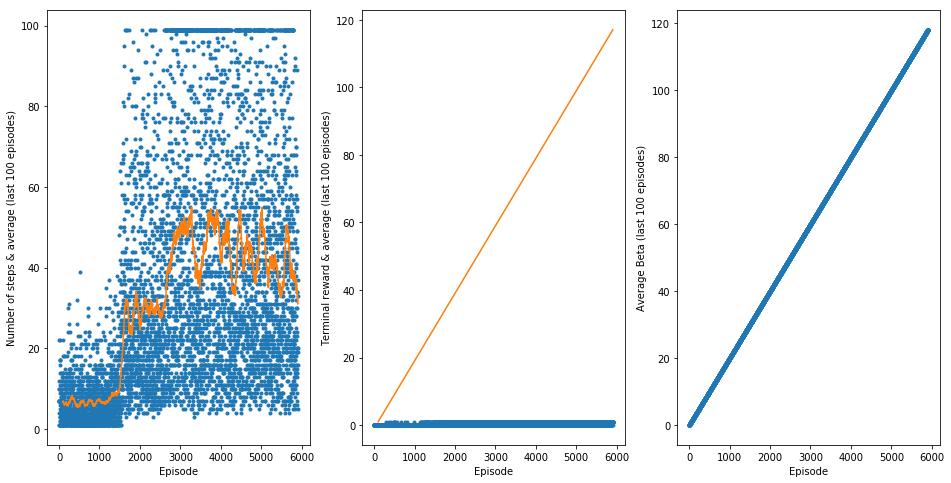

In [6]:
if __name__ == "__main__":
    
    arguments = "-a q_learning -p softmax -t 0.76 -ws 100"

    if sys.argv and "-f" not in sys.argv:
        arguments = ""
        for arg in sys.argv[1:]:
            arguments += arg + " "

    episode, score = main(arguments)